# Fine-Tuning GPT-2 on Encrypted Data with LoRA and Concrete ML

In this notebook, we perform fine-tuning of a GPT-2 model using LoRA and Concrete ML.

In [1]:
# Import necessary libraries
import math

import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from utils_lora import generate_and_print, print_weights_and_size

from concrete.ml.torch.hybrid_model import HybridFHEModel
from concrete.ml.torch.lora import LoraTraining, get_remote_names

# Set random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [2]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
generate_and_print(
    prompt="What is FHE?",
    model=model,
    tokenizer=tokenizer,
    seed=SEED,
)

What is FHE? FHE is a new type of energy storage that is designed to be used in a variety of applications. It is used to store energy in


In [4]:
# Apply LoRA to the model
# target_modules can be set to "all-linear"
# to target all modules. By default only the
# c_attn projection are fine-tuned with lora.
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model, peft_config)

In [5]:
# Set up LoRA training
lora_training = LoraTraining(peft_model)

LoRA layers detected in the model.


In [6]:
# Prepare dataset for fine-tuning
BLOCK_SIZE = 128

# Read lines from the file
with open("data_finetune/what_is_fhe.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Remove empty lines and strip whitespace
lines = [line.strip() for line in lines if line.strip()]

# Group lines into question-answer pairs
examples = []
for i in range(0, len(lines) - 1, 2):
    question = lines[i]
    answer = lines[i + 1]
    examples.append({"question": question, "answer": answer})

# Create a Dataset object from the list of examples
dataset = Dataset.from_list(examples)


# Tokenization function
def tokenize_function(examples):
    input_ids_list = []
    labels_list = []
    attention_masks_list = []
    for question, answer in zip(examples["question"], examples["answer"]):
        # Tokenize question and answer separately
        question_encoding = tokenizer(
            question, add_special_tokens=False, truncation=True, max_length=BLOCK_SIZE // 2
        )
        answer_encoding = tokenizer(
            answer, add_special_tokens=False, truncation=True, max_length=BLOCK_SIZE // 2 - 1
        )

        # Build input_ids
        input_ids = (
            question_encoding["input_ids"]
            + [tokenizer.eos_token_id]
            + answer_encoding["input_ids"]
            + [tokenizer.eos_token_id]
        )

        # Build labels: -100 for question tokens and eos token after question
        labels = (
            [-100] * len(question_encoding["input_ids"])
            + [-100]  # For the eos token after question
            + answer_encoding["input_ids"]
            + [tokenizer.eos_token_id]
        )

        # Create attention mask: 1 for real tokens, 0 for padding
        attention_mask = [1] * len(input_ids)

        # Pad/truncate to BLOCK_SIZE
        padding_length = BLOCK_SIZE - len(input_ids)
        if padding_length > 0:
            input_ids += [tokenizer.pad_token_id] * padding_length
            labels += [-100] * padding_length
            attention_mask += [0] * padding_length
        else:
            input_ids = input_ids[:BLOCK_SIZE]
            labels = labels[:BLOCK_SIZE]
            attention_mask = attention_mask[:BLOCK_SIZE]

        input_ids_list.append(input_ids)
        labels_list.append(labels)
        attention_masks_list.append(attention_mask)

    return {
        "input_ids": input_ids_list,
        "labels": labels_list,
        "attention_mask": attention_masks_list,
    }


# Apply the tokenization
tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["question", "answer"]
)

# Since we've already handled padding and labels, we can use a custom data collator


def data_collator(features):
    batch = {}
    batch["input_ids"] = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
    batch["labels"] = torch.tensor([f["labels"] for f in features], dtype=torch.long)
    batch["attention_mask"] = torch.tensor(
        [f["attention_mask"] for f in features], dtype=torch.long
    )
    return batch

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

In [7]:
# Define training arguments
EPOCHS = 40
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=1,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=2e-3,
    lr_scheduler_type="linear",
    seed=SEED,
    warmup_steps=10,
    weight_decay=0.01,
    prediction_loss_only=True,
)


def causal_lm_loss(logits, labels, ignore_index=-100):
    # Shift logits and labels for next-token prediction
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tensors
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)

    # Compute the loss, ignoring padding tokens
    loss = torch.nn.functional.cross_entropy(
        shift_logits, shift_labels, ignore_index=ignore_index, reduction="mean"
    )

    return loss

In [8]:
# Initialize Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets,
    data_collator=data_collator,
)

# Prepare for training
train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lr_scheduler = trainer.lr_scheduler
optimizer = trainer.optimizer

In [9]:
# Get the names of the remote modules (layers to be converted to FHE)
remote_names = get_remote_names(lora_training, include_embedding_layers=False)

In [10]:
# Create the HybridFHEModel with the specified remote modules
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [11]:
# Prepare input data for calibration
input_tensor = torch.randint(
    0, tokenizer.vocab_size, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE), dtype=torch.long
)
label_tensor = torch.randint(
    0, tokenizer.vocab_size, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE), dtype=torch.long
)
attention_mask = torch.ones((PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE), dtype=torch.long)

inputset = (input_tensor, label_tensor, attention_mask)

In [12]:
# Calibrate and compile the model
lora_training.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=16)
lora_training.toggle_calibrate(enable=False)

In [13]:
def train_custom_model(
    hybrid_model, train_dataloader, training_args, tokenizer, fhe="disable"
):  # pylint: disable=too-many-locals
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    peft_model.train()
    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []

    # Generate text before the first epoch
    print("Generating text before the first epoch:\n")
    prompt = "What is FHE?"
    hybrid_model.set_fhe_mode("disable")
    generate_and_print(prompt, peft_model, tokenizer, SEED)
    hybrid_model.set_fhe_mode(fhe)

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        for _, batch in enumerate(train_dataloader):
            total_batched_samples += 1
            batch = {k: v.to(device) for k, v in batch.items()}

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            loss, grad_norm = hybrid_model(
                (batch["input_ids"], batch["labels"], batch["attention_mask"]), fhe=fhe
            )

            # Optimizer step
            optimizer.step()

            # Learning rate scheduler step
            lr_scheduler.step()

            total_loss += loss.item()
            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1] if grad_norms else None

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        # Generate text after each epoch
        prompt = "What is FHE?"
        hybrid_model.set_fhe_mode("disable")
        generate_and_print(prompt, peft_model, tokenizer, SEED)
        hybrid_model.set_fhe_mode(fhe)

        print("\n" + "-" * 50)
        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        peft_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Generating text before the first epoch:



What is FHE? FHE is a new type of energy that is used to generate electricity. It is the most energy-efficient form of electricity, and it


Epoch 1/40, Loss: 31.7653, grad norm: None, lr: 0.0018000000000000002


Training Progress:   2%|▎         | 1/40 [00:47<31:09, 47.93s/it]

What is FHE? FHE is a non-invasive, noninvasible, and nonflammable, biocompatible, anti-inflammatory

--------------------------------------------------


Epoch 2/40, Loss: 26.4889, grad norm: None, lr: 0.0019542857142857144


Training Progress:   5%|▌         | 2/40 [01:18<23:58, 37.85s/it]

What is FHE? FHE is a simple, fast, efficient, and highly secure encryption scheme. It can be used to encrypt data, or to decrypt it

--------------------------------------------------


Epoch 3/40, Loss: 23.2506, grad norm: None, lr: 0.0019028571428571428


Training Progress:   8%|▊         | 3/40 [01:40<18:46, 30.44s/it]

What is FHE? FHe is the principle of the F-layer, which is a layer of information that is encrypted using encrypted data. Fhe is used to make

--------------------------------------------------


Epoch 4/40, Loss: 20.5768, grad norm: None, lr: 0.0018514285714285714


Training Progress:  10%|█         | 4/40 [02:13<18:55, 31.53s/it]

What is FHE? FHE is a non-static structure that can be used to perform computations on encrypted data. It is used for cryptographic computables,

--------------------------------------------------


Epoch 5/40, Loss: 19.3337, grad norm: None, lr: 0.0018000000000000002


Training Progress:  12%|█▎        | 5/40 [02:42<17:54, 30.70s/it]

What is FHE? FHE is a type of Fully Homomorphic Encryption (Fully Homogeneous Encrypted) that can be used to perform computationally computably

--------------------------------------------------


Epoch 6/40, Loss: 17.1813, grad norm: None, lr: 0.0017485714285714288


Training Progress:  15%|█▌        | 6/40 [03:11<17:03, 30.11s/it]

What is FHE? FHE is a type of Fully Homomorphic Encryption (FHO) that allows computations to be performed on encrypted data without requiring any

--------------------------------------------------


Epoch 7/40, Loss: 14.8665, grad norm: None, lr: 0.0016971428571428571


Training Progress:  18%|█▊        | 7/40 [03:43<16:48, 30.55s/it]

What is FHE? FHE is a type of Fully Homomorphic Encryption (FHO) that allows computations on encrypted data without requiring validation. It allows

--------------------------------------------------


Epoch 8/40, Loss: 14.3393, grad norm: None, lr: 0.0016457142857142857


Training Progress:  20%|██        | 8/40 [04:14<16:28, 30.89s/it]

What is FHE? FHE is a fast-growing encryption algorithm that allows for efficient computations without requiring any additional hardware hardware. It is designed to support both

--------------------------------------------------


Epoch 9/40, Loss: 13.2082, grad norm: None, lr: 0.0015942857142857143


Training Progress:  22%|██▎       | 9/40 [04:43<15:31, 30.06s/it]

What is FHE? FHO is the most widely used encryption algorithm, and it has been used extensively in more than 1,000 applications. It has also been applied to

--------------------------------------------------


Epoch 10/40, Loss: 12.4083, grad norm: None, lr: 0.001542857142857143


Training Progress:  25%|██▌       | 10/40 [05:15<15:24, 30.80s/it]

What is FHE? FHE is a type of fast-forward (FHT) cipher that can be used to perform computations on encrypted data without requiring the

--------------------------------------------------


Epoch 11/40, Loss: 10.8827, grad norm: None, lr: 0.0014914285714285713


Training Progress:  28%|██▊       | 11/40 [05:46<14:52, 30.77s/it]

What is FHE? FITTITTING Fittings (FITTINGS) is a term that describes how many different types of FITS exist in the world. F

--------------------------------------------------


Epoch 12/40, Loss: 9.8909, grad norm: None, lr: 0.0014399999999999999


Training Progress:  30%|███       | 12/40 [06:18<14:37, 31.33s/it]

What is FHE? Fully Fully Fully Fully Homomorphic Encryption (FHE) is a technique that allows data to be encrypted without ever decryption.

--------------------------------------------------


Epoch 13/40, Loss: 9.1316, grad norm: None, lr: 0.0013885714285714287


Training Progress:  32%|███▎      | 13/40 [06:48<13:48, 30.69s/it]

What is FHE? FITTHEHE(FITT(HE))FHE(-FittHE)_(Fully(Full(Hellon)))(0.0

--------------------------------------------------


Epoch 14/40, Loss: 8.5487, grad norm: None, lr: 0.0013371428571428573


Training Progress:  35%|███▌      | 14/40 [07:17<13:07, 30.31s/it]

What is FHE? FHO is the F HE-HE-tree, which consists of a F-FHE transformation that transforms a plain-text data into encrypted data

--------------------------------------------------


Epoch 15/40, Loss: 8.3545, grad norm: None, lr: 0.0012857142857142859


Training Progress:  38%|███▊      | 15/40 [07:47<12:36, 30.24s/it]

What is FHE? FHE is a Fully Homomorphic Encryption (Fhi) that allows encrypted data to be decrypted without any additional information being sent through the

--------------------------------------------------


Epoch 16/40, Loss: 7.5394, grad norm: None, lr: 0.0012342857142857142


Training Progress:  40%|████      | 16/40 [08:27<13:12, 33.02s/it]

What is FHE? FHE is a fast Fully-Fhiomorphic scheme that can be applied to encrypted data in a variety of ways. It consists of a

--------------------------------------------------


Epoch 17/40, Loss: 6.5157, grad norm: None, lr: 0.0011828571428571428


Training Progress:  42%|████▎     | 17/40 [08:55<12:08, 31.67s/it]

What is FHE? FHE is a Fully Homomorphic Encryption (Fhi) that allows encrypted data to be decrypted without ever exposing the underlying computation. This

--------------------------------------------------


Epoch 18/40, Loss: 5.7978, grad norm: None, lr: 0.0011314285714285714


Training Progress:  45%|████▌     | 18/40 [09:24<11:21, 30.98s/it]

What is FHE? FHE is a fast-growing fast growing fast fast. It can grow over several hours, and can even grow even larger without needing to decrypt

--------------------------------------------------


Epoch 19/40, Loss: 6.0067, grad norm: None, lr: 0.00108


Training Progress:  48%|████▊     | 19/40 [09:56<10:54, 31.17s/it]

What is FHE? FHE is a Fully Homomorphic Encryption (FHO) technique that allows encrypted data to be processed in parallel without exposing the data. This

--------------------------------------------------


Epoch 20/40, Loss: 4.9995, grad norm: None, lr: 0.0010285714285714284


Training Progress:  50%|█████     | 20/40 [10:33<10:55, 32.76s/it]

What is FHE? Fully Homomorphic Encryption (FHE) allows secure, encrypted data to be accessed without exposing the data. This allows for secure computations on encrypted

--------------------------------------------------


Epoch 21/40, Loss: 4.6647, grad norm: None, lr: 0.0009771428571428572


Training Progress:  52%|█████▎    | 21/40 [11:05<10:22, 32.75s/it]

What is FHE? GHE is a type of Fully Homomorphic Encryption (FHE) where the ciphertext is encrypted only on the top level of the encryption process

--------------------------------------------------


Epoch 22/40, Loss: 4.6801, grad norm: None, lr: 0.0009257142857142857


Training Progress:  55%|█████▌    | 22/40 [11:35<09:33, 31.85s/it]

What is FHE? Fully Homomorphic Encryption (FHE) allows data to be processed by any computer on a single node in a encrypted environment. This makes it possible

--------------------------------------------------


Epoch 23/40, Loss: 4.1295, grad norm: None, lr: 0.0008742857142857144


Training Progress:  57%|█████▊    | 23/40 [12:08<09:07, 32.19s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast fast fully-homomorphic encryption that can be safely applied to encrypted data without needing to

--------------------------------------------------


Epoch 24/40, Loss: 3.6438, grad norm: None, lr: 0.0008228571428571429


Training Progress:  60%|██████    | 24/40 [12:41<08:39, 32.49s/it]

What is FHE? GHE is a type of Fully Homomorphic Encryption (FHE) that allows secure computations on encrypted data without needing to decrypt it. F

--------------------------------------------------


Epoch 25/40, Loss: 3.7342, grad norm: None, lr: 0.0007714285714285715


Training Progress:  62%|██████▎   | 25/40 [13:10<07:48, 31.26s/it]

What is FHE? Fully Homomorphic Encryption (FHE) involves computing a mathematical operation that updates the encrypted state on the hardware. The operation can be performed on encrypted

--------------------------------------------------


Epoch 26/40, Loss: 3.3181, grad norm: None, lr: 0.0007199999999999999


Training Progress:  65%|██████▌   | 26/40 [13:39<07:08, 30.60s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a growing industry, with growing demand for high-quality FH programs that can be implemented in various

--------------------------------------------------


Epoch 27/40, Loss: 2.8375, grad norm: None, lr: 0.0006685714285714286


Training Progress:  68%|██████▊   | 27/40 [14:10<06:41, 30.88s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a technique that allows secure, mutable data to be processed by the encryption process. This enables the

--------------------------------------------------


Epoch 28/40, Loss: 3.0023, grad norm: None, lr: 0.0006171428571428571


Training Progress:  70%|███████   | 28/40 [14:44<06:20, 31.71s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a technique that allows secure, immutable data to store information or perform computations on encrypted data without needing

--------------------------------------------------


Epoch 29/40, Loss: 2.6809, grad norm: None, lr: 0.0005657142857142857


Training Progress:  72%|███████▎  | 29/40 [15:17<05:54, 32.21s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast growing industry that is growing rapidly. Fhessian (Fast Growing Industry) has been growing

--------------------------------------------------


Epoch 30/40, Loss: 2.4333, grad norm: None, lr: 0.0005142857142857142


Training Progress:  75%|███████▌  | 30/40 [15:45<05:09, 30.91s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a technique that allows secure, mutable data to be processed by the program's hardware hardware drivers without

--------------------------------------------------


Epoch 31/40, Loss: 2.4024, grad norm: None, lr: 0.00046285714285714284


Training Progress:  78%|███████▊  | 31/40 [16:14<04:33, 30.37s/it]

What is FHE? FHE is a type of encryption algorithm that can be applied to encrypted data without needing a decryptant. It supports both G and PHE

--------------------------------------------------


Epoch 32/40, Loss: 2.0085, grad norm: None, lr: 0.00041142857142857143


Training Progress:  80%|████████  | 32/40 [16:44<04:01, 30.19s/it]

What is FHE? FHE is a type of encryption algorithm that can be applied to reduce the number of computations required for a ciphertext. It can also

--------------------------------------------------


Epoch 33/40, Loss: 1.9126, grad norm: None, lr: 0.00035999999999999997


Training Progress:  82%|████████▎ | 33/40 [17:14<03:30, 30.12s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast FH model that supports infinite computation and can handle sensitive data without needing to decrypt it.

--------------------------------------------------


Epoch 34/40, Loss: 2.0537, grad norm: None, lr: 0.00030857142857142856


Training Progress:  85%|████████▌ | 34/40 [17:50<03:10, 31.82s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast growing industry that is growing fast and slow. FH is an incredibly fast growth rate,

--------------------------------------------------


Epoch 35/40, Loss: 2.1758, grad norm: None, lr: 0.0002571428571428571


Training Progress:  88%|████████▊ | 35/40 [18:18<02:34, 30.92s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a technique that allows secure, mutable data to be processed by the application state-free. It

--------------------------------------------------


Epoch 36/40, Loss: 1.7766, grad norm: None, lr: 0.00020571428571428572


Training Progress:  90%|█████████ | 36/40 [18:48<02:02, 30.65s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a technique that allows secure, mutable data to be processed by the application state-free. It

--------------------------------------------------


Epoch 37/40, Loss: 1.8864, grad norm: None, lr: 0.00015428571428571428


Training Progress:  92%|█████████▎| 37/40 [19:22<01:34, 31.57s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a technique that allows secure, mutable data to be processed by the application state machine (PAS

--------------------------------------------------


Epoch 38/40, Loss: 1.7823, grad norm: None, lr: 0.00010285714285714286


Training Progress:  95%|█████████▌| 38/40 [19:51<01:01, 30.70s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast FH model that supports infinite computation and can handle sensitive data like secure computations. F

--------------------------------------------------


Epoch 39/40, Loss: 1.8798, grad norm: None, lr: 5.142857142857143e-05


Training Progress:  98%|█████████▊| 39/40 [20:27<00:32, 32.18s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast FH model that supports infinite computation and can handle sensitive information, making it ideal for use

--------------------------------------------------


Epoch 40/40, Loss: 1.6045, grad norm: None, lr: 0.0


Training Progress: 100%|██████████| 40/40 [21:01<00:00, 32.88s/it]

What is FHE? Fully Homomorphic Encryption (FHE) is a fast FH model that supports infinite computation and can handle sensitive information, making it ideal for use

--------------------------------------------------


Training Progress: 100%|██████████| 40/40 [21:01<00:00, 31.54s/it]

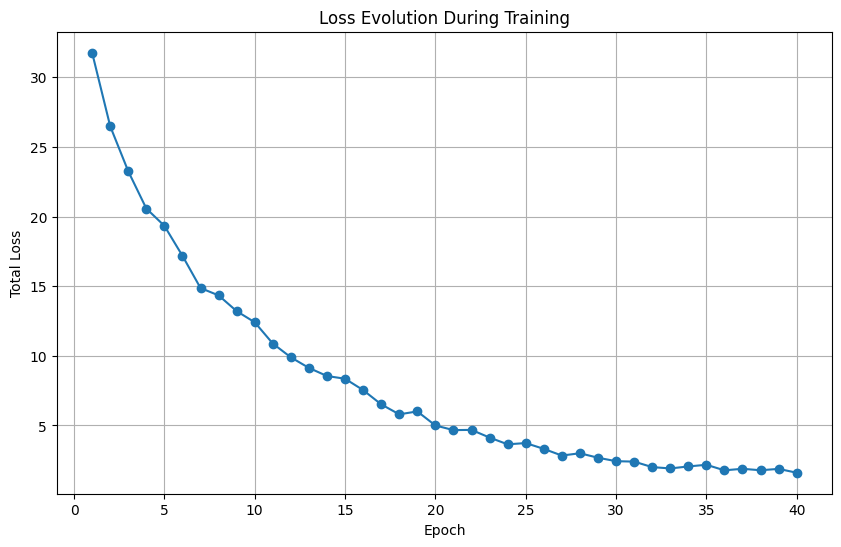

In [14]:
# Avoid parallelism error from HuggingFace during training
tokenizer.parallelism = False

# Train the model using FHE simulation
train_custom_model(hybrid_model, train_dataloader, training_args, tokenizer, fhe="disable")

Note that our goal is to showcase the use of FHE for encrypted fine-tuning. The dataset consists of 68 examples and a total of 2,386 tokens, which is relatively small. Despite its limited size, which offers little support for the model's learning process, it still manages to produce interesting results.

In [15]:
# Get the fine-tuned model
fine_tuned_model = hybrid_model.model.inference_model

# Set FHE mode to disable for text generation
hybrid_model.set_fhe_mode("disable")

In [16]:
# Inference using the fine-tuned model with LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

fine_tuned_model.enable_adapter_layers()
prompt = "Who invented Fully Homomorphic Encryption?"
generate_and_print(prompt, fine_tuned_model, tokenizer, SEED)

Who invented Fully Homomorphic Encryption? Fully Homomorphized Encrypted Data (FHE) was first proposed by Craig Gentry in 2009. His breakthrough demonstrated how to perform


In [17]:
# Original inference without LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

peft_model.disable_adapter_layers()

prompt = "Who invented Fully Homomorphic Encryption?"
generate_and_print(prompt, peft_model, tokenizer, SEED)

Who invented Fully Homomorphic Encryption? The first time I saw a computer fully fully homomorphic encryption, I was in the middle of a conversation with a friend of mine who was


In [18]:
peft_model.enable_adapter_layers()

# Print weights and model size
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124734720
Total number of LoRA weights: 294912


In [19]:
# Note: Around 95% of the remaining weights are from the embedding layers (wpe and wte)
# as well as the final lm_head layer.